In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline
import xgboost as xgb
from sklearn import linear_model
import operator
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics
from sklearn.cross_validation import train_test_split

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Read the data and check the shapes

In [2]:
def load_data():
    train_df = pd.read_csv('../data/train.csv')
    x_test_df = pd.read_csv('../data/test.csv')
    
    y_train = train_df['price_doc'].as_matrix()
    x_train_df = train_df.drop(['price_doc'],1)
    return (x_train_df, y_train, x_test_df)

#x_train_df, y_train, x_test_df = load_data()

def impute_data(df):
    columns_with_nulls = df.columns[df.isnull().any()].tolist()
    string_columns = df.select_dtypes(include=['object']).columns.tolist()

    for col in columns_with_nulls:
        if col in string_columns:
            #populate the most common categorical value
            df[col] = df[col].fillna(df[col].value_counts().index[0])
        else:
            #populate with mean of column for missing values
            df[col] = df[col].fillna(np.mean(df[col]))
    return df   

def add_features(df):
    x_dt = pd.to_datetime(df['timestamp'],format='%Y-%m-%d')
    df['year'] = x_dt.dt.year
    df['month'] =  x_dt.dt.month
    df['day'] = x_dt.dt.day
    df['quarter'] = x_dt.dt.quarter
    df['days_since'] = (x_dt - x_dt.min()).astype('timedelta64[D]')
    df['dow'] = x_dt.dt.dayofweek
    
    # Add month-year
    month_year = (x_dt.dt.month + x_dt.dt.year * 100)
    month_year_cnt_map = month_year.value_counts().to_dict()
    df['month_year_cnt'] = month_year.map(month_year_cnt_map)

    # Add week-year count
    week_year = (x_dt.dt.weekofyear + x_dt.dt.year * 100)
    week_year_cnt_map = week_year.value_counts().to_dict()
    df['week_year_cnt'] = week_year.map(week_year_cnt_map)

    # Other feature engineering
    df['rel_floor'] = df['floor'] / df['max_floor'].astype(float)
    df['rel_kitch_sq'] = df['kitch_sq'] / df['full_sq'].astype(float)
    return df

def onehot_encode(df,include_string_cols=True,other_cols=[]):
    cols = other_cols
    if include_string_cols:
        cols = cols.append(df.select_dtypes(include=['object']).columns.tolist())
    return pd.get_dummies(df,columns=cols)

def factorize(df):
    string_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in string_cols:
        df[col] = pd.factorize(df[col])[0]
    return df
    
    

In [10]:
#load data
x_train_df, y_train_df, x_test_df = load_data()

#we should on-hot encode test and train togather as labels should math
x_all_df = x_train_df.append(x_test_df)
string_columns = x_train_df.select_dtypes(include=['object']).columns.tolist()

#one hot encode string columns
x_all_onehot_df = pd.get_dummies(x_all_df,columns=string_columns)
print('shape after onehot encoding: ', x_all_onehot_df.shape)

#again separate train and test features
x_train_onehot = x_all_onehot_df[0:x_train_df.shape[0]].as_matrix()
x_test_onehot = x_all_onehot_df[x_train_df.shape[0]::].as_matrix()

('shape after onehot encoding: ', (38133, 1887))


### Train the model

In [38]:
model = xgb.XGBRegressor()
model.fit(x_train_onehot, y_train_df.as_matrix())

XGBRegressor(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, nthread=-1, objective='reg:linear', seed=0,
       silent=True, subsample=1)

In [141]:
y_test = model.predict(x_test_onehot)
# y_pred = model.predict()

### Submission 1
So we are submitting without any feature engineering or parameter optmization for xgboost. Some columns could also be wrongly classified as string columns and one-hot encoded

In [142]:
submission = pd.DataFrame({
    'id': x_test['id'],
    'price_doc': y_test
})
submission.to_csv('./data/submission_v0.12.csv',index=False)

#Ranked 836 and score was 0.32577

### Submission 2

In [24]:
x_train_df, y_train, x_test_df = load_data()

#we should on-hot encode test and train togather as labels should math
x_all_df = x_train_df.append(x_test_df)
string_columns = x_train_df.select_dtypes(include=['object']).columns.tolist()

#let us check what the string columns are
string_columns

['timestamp',
 'product_type',
 'sub_area',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line',
 'ecology']

Timestamp is getting identifed as string. Lets fix this

In [26]:
x_all_df = add_features(x_all_df)

#one hot encode string columns
string_columns = x_train_df.select_dtypes(include=['object']).columns.tolist()
x_all_onehot_df = pd.get_dummies(x_all_df,columns=string_columns)
print('shape after onehot encoding: ', x_all_onehot_df.shape)

#again separate train and test features
x_train_onehot = x_all_onehot_df[0:x_train_df.shape[0]].as_matrix()
x_test_onehot = x_all_onehot_df[x_train_df.shape[0]::].as_matrix()

#train
model = xgb.XGBRegressor(max_depth=6,learning_rate=0.05)
model.fit(x_train_onehot, y_train)

#predict
y_test = model.predict(x_test_onehot)

submission = pd.DataFrame({
    'id': x_test_df['id'],
    'price_doc': y_test
})
submission.to_csv('./data/submission_v0.31.csv',index=False)


('shape after onehot encoding: ', (38133, 1892))


In [21]:

submission = pd.DataFrame({
    'id': x_test_df['id'],
    'price_doc': y_test
})
submission.to_csv('./data/submission_v0.3.csv',index=False)

1. result is 0.33636 (if I drop datetime column), which is worse than submisison 1
2. result is 0.32501 and rank is 767, if I retain the timestamp column, and increase the max_depth to 6 and change learning rate to 0.05
3. result is 0.34385, when I increased depth to 20 and added the feature 'days_since'
4. result is 0.32798, when I set max_depth to 6
5. result is 0.32501. So 'days_since' has no impact


In [ ]:
#we should on-hot encode test and train togather as labels should math
# x_all_df = x_train_df.append(x_test_df)

#one hot encode string columns
x_all_onehot_df = pd.get_dummies(x_all_df,columns=string_columns)
print('shape after onehot encoding: ', x_all_onehot_df.shape)

#again separate train and test features
x_train_onehot = x_all_onehot_df[0:x_train_df.shape[0]].as_matrix()
x_test_onehot = x_all_onehot_df[x_train_df.shape[0]::].as_matrix()

#train
model = xgb.XGBRegressor(max_depth=6,learning_rate=0.1)
model.fit(x_train_onehot, y_train)

#predict
y_test = model.predict(x_test_onehot)


submission_v4 = pd.DataFrame({
    'id': x_test['id'],
    'price_doc': y_test
})
submission_v4.to_csv('./data/submission_v0.4.csv',index=False)

#### Feature Importance
Let us understand the feature importance

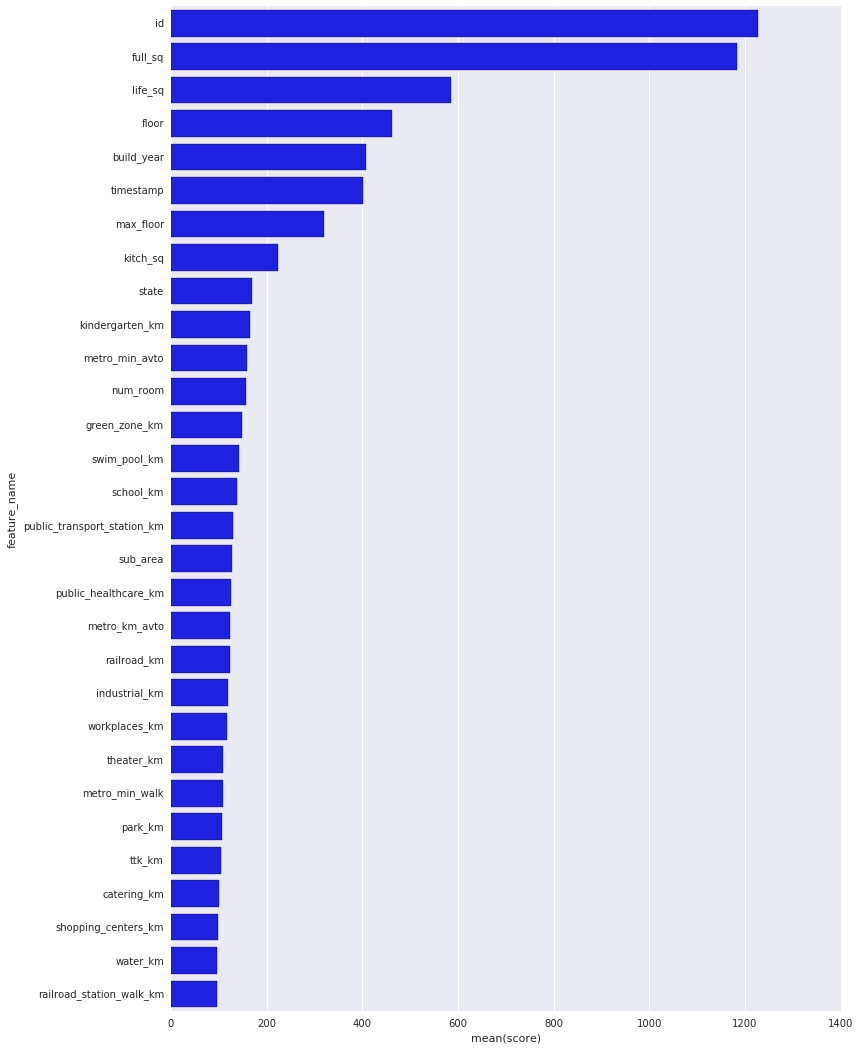

In [41]:
#dataframe of features
feature_scores_df = pd.DataFrame(list(model._Booster.get_fscore().items()),columns=['feature_name','score'])
feature_scores_df = feature_scores_df.sort_values('score',ascending=False)
fig, ax = plt.subplots(figsize=(12,18))

sns.barplot(x="score", y="feature_name", data=feature_scores_df.head(30),label="Feature Importance", color="b")

We can clearly see that id field is given the highest importance, which is wrong. 

### Submission 3

In [3]:
x_train_df, y_train, x_test_df = load_data()
x_all_df = x_train_df.append(x_test_df)
x_all_df = add_features(x_all_df)
x_all_df = x_all_df.drop(['id','timestamp'],axis=1)
x_all_onehot_df = onehot_encode(x_all_df,other_cols=['month','quarter'])

#again separate train and test features
x_train_onehot_df = x_all_onehot_df[0:x_train_df.shape[0]]
x_test_onehot_df = x_all_onehot_df[x_train_df.shape[0]::]

#train
model = xgb.XGBRegressor(max_depth=6,learning_rate=0.1,n_estimators=300)
# model.fit(x_train_onehot, y_train, eval_metric='mlogloss',verbose=True)
model.fit(x_train_onehot_df, y_train,verbose=True)


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

/notebooks/notebooks


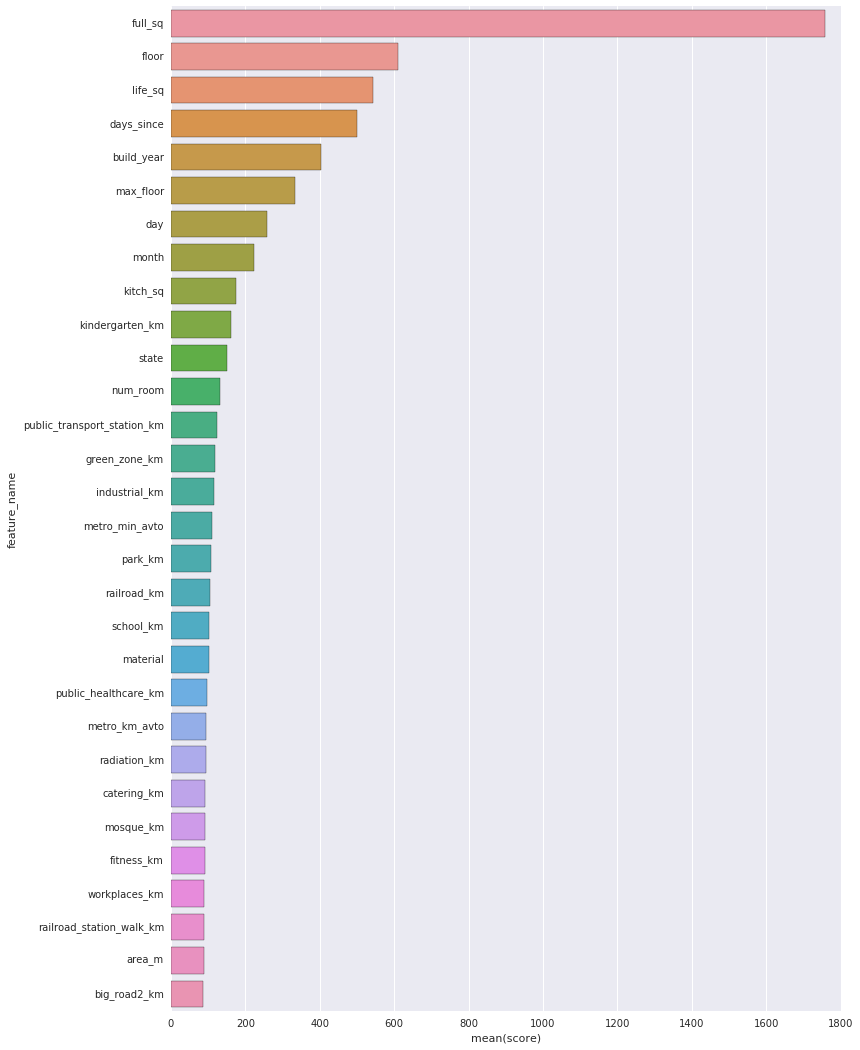

In [7]:
feature_scores = pd.DataFrame(list(model.booster().get_fscore().items()),columns=['feature_name','score'])
feature_scores = feature_scores.sort_values('score',ascending=False).head(30)
fig, ax = plt.subplots(figsize=(12,18))
sns.barplot(x='score', y='feature_name',data=feature_scores)

#predict
y_test = model.predict(x_test_onehot_df)

# print(x_test_onehot_df)

submission = pd.DataFrame({
    'id': x_test_df['id'].tolist(),
    'price_doc': y_test
})
!pwd
submission.to_csv('../data/submission_v0.5.csv',index=False)

### Submission 4
We will try to factorize (change from string to int, without one-hot)

In [18]:
x_train_df, y_train, x_test_df = load_data()
x_all_df = x_train_df.append(x_test_df)
x_all_df = add_features(x_all_df)
x_all_df = x_all_df.drop(['id','timestamp'],axis=1)
x_all_df = factorize(x_all_df)

#train
model = xgb.XGBRegressor(max_depth=6,learning_rate=0.1,n_estimators=300)
model.fit(x_all_df[0:x_train_df.shape[0]], y_train,verbose=True)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [20]:
#predict
y_test = model.predict(x_all_df[x_train_df.shape[0]::])

# print(x_test_onehot_df)

submission = pd.DataFrame({
    'id': x_test_df['id'].tolist(),
    'price_doc': y_test
})
!pwd
submission.to_csv('../data/submission_v0.6.csv',index=False)

/notebooks/notebooks


Result is 0.32550. No improvement

### Submission 7
Avoid overfitting by using the right value for 'num_boost_round'. Two ways to determine it
1. Create a Validation set from training data and stop when RMSE on validation set has not increased in 'early_stopping_rounds'
2. Use Cross Validation. 

We will look at both approaches below.

In [3]:
x_train_df, y_train, x_test_df = load_data()

x_all_df = x_train_df.append(x_test_df)
x_all_df = add_features(x_all_df)
x_all_df = x_all_df.drop(['id','timestamp'],axis=1)
x_all_df = factorize(x_all_df)

#convert into numpy values
x_train = x_all_df[0:x_train_df.shape[0]].values
x_test = x_all_df[x_train_df.shape[0]::].values

print(x_all_df.get_dtype_counts())


x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# create dmatrix
feature_names = x_all_df.columns.tolist()
dtrain = xgb.DMatrix(x_train2,y_train2, feature_names=feature_names)
dval = xgb.DMatrix(x_val, y_val, feature_names=feature_names)
dtest = xgb.DMatrix(x_test,feature_names=feature_names)



partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000,evals=[(dval, 'valx')],
                         early_stopping_rounds=21, verbose_eval=20)
num_boost_round = partial_model.best_iteration

float64    123
int64      176
dtype: int64
[0]	valx-rmse:8.23582e+06
Will train until valx-rmse hasn't improved in 21 rounds.
[20]	valx-rmse:4.14852e+06
[40]	valx-rmse:3.05661e+06
[60]	valx-rmse:2.80477e+06
[80]	valx-rmse:2.73484e+06
[100]	valx-rmse:2.69525e+06
[120]	valx-rmse:2.66532e+06
[140]	valx-rmse:2.65288e+06
[160]	valx-rmse:2.64345e+06
[180]	valx-rmse:2.63393e+06
[200]	valx-rmse:2.6235e+06
[220]	valx-rmse:2.61879e+06
[240]	valx-rmse:2.61199e+06
[260]	valx-rmse:2.6063e+06
[280]	valx-rmse:2.59954e+06
[300]	valx-rmse:2.59378e+06
[320]	valx-rmse:2.59008e+06
[340]	valx-rmse:2.58999e+06
[360]	valx-rmse:2.58915e+06
[380]	valx-rmse:2.58774e+06
[400]	valx-rmse:2.58526e+06
[420]	valx-rmse:2.58429e+06
[440]	valx-rmse:2.58185e+06
[460]	valx-rmse:2.58148e+06
[480]	valx-rmse:2.5818e+06
Stopping. Best iteration:
[459]	valx-rmse:2.58125e+06



In [4]:
dtrain_all = xgb.DMatrix(x_train,y_train, feature_names=feature_names)
#model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

In [11]:
# dtest
y_pred = model.predict(dtest)
submission = pd.DataFrame({
    'id': x_test_df['id'].tolist(),
    'price_doc': y_pred
})

submission.to_csv('../data/submission_v0.71.csv',index=False)


Score is 0.32501. Position is 883.

#### Let us try cross validation
to find out num_boost_round

In [5]:
cvresult = xgb.cv(xgb_params, dtrain_all, num_boost_round=num_boost_round, nfold=10,
            metrics='rmse', early_stopping_rounds=20)

In [7]:
cvresult.shape

(459, 4)

### Submission 8
GridSeacrch CV to optimize params
https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Parameter_Tuning_XGBoost_with_Example/XGBoost%20models.ipynb

In [6]:
x_train_df, y_train, x_test_df = load_data()

x_all_df = x_train_df.append(x_test_df)
x_all_df = add_features(x_all_df)
x_all_df = x_all_df.drop(['id','timestamp'],axis=1)
x_all_df = factorize(x_all_df)

#convert into numpy values
x_train = x_all_df[0:x_train_df.shape[0]].values
x_test = x_all_df[x_train_df.shape[0]::].values

In [7]:
xgb_model = xgb.XGBRegressor(objective= 'reg:linear',seed=1)

param = {
    'n_estimators':[100,500,1000],
    'max_depth':[6,8,12],
    'min_child_weight':[2,4,6], #default 1
    'colsample_bytree':[0.6,0.8], #default 1
    'colsample_bylevel':[0.6,0.8] #default 1
}

gsearch1 = GridSearchCV(estimator=xgb_model, param_grid=param,scoring='mean_absolute_error',cv=10,verbose=1,n_jobs=6)
gsearch1.fit(x_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 42.4min


KeyboardInterrupt: 

### Regression - time series
trees cannot take advantage of the time series information - my understanding (could be wrong). So let us try regression and combine the results

In [15]:
x_train_df, y_train, x_test_df = load_data()
x_all_df = x_train_df.append(x_test_df)
x_all_df = impute_data(x_all_df)

x_all_df = add_features(x_all_df)
x_all_df = x_all_df.drop(['id','timestamp'],axis=1)

#one hot encode string columns
x_all_onehot_df = onehot_encode(x_all_df,other_cols=['month','quarter'])
# columns_with_nulls = x_all_df.colxgb.plot_importance(bst)umns[x_all_df.isnull().any()].tolist()

In [244]:
regr = linear_model.LinearRegression()
regr.fit(x_all_onehot_df[0:x_train_df.shape[0]].as_matrix(),y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [245]:
regr_y_pred = regr.predict(x_all_onehot_df[x_train_df.shape[0]::].as_matrix())

submission_v5 = pd.DataFrame({
    'id': x_test['id'],
    'price_doc': regr_y_pred
})
submission_v5.to_csv('./data/submission_regr_v0.5.csv',index=False)

In [28]:
x_all_onehot_df.columns
model

XGBRegressor(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=100, nthread=-1, objective='reg:linear', seed=0,
       silent=True, subsample=1)

In [3]:
train_df = pd.read_csv('./data/train.csv',parse_dates=['timestamp'])

In [19]:
dtype_df = train_df.dtypes.reset_index()

In [23]:
dtype_df.columns = ['col_name','col_type']
dtype_df.groupby('col_type').aggregate('count').reset_index()

,col_type,col_name
0,int64,157
1,datetime64[ns],1
2,float64,119
3,object,15


In [35]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

### Important features
Let us use xgb.train to an idea of important parameters

In [38]:
x_train_df, y_train, x_test_df = load_data()

for f in x_train_df.columns:
    if x_train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train_df[f].values)) 
        x_train_df[f] = lbl.transform(list(x_train_df[f].values))
        
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# ??xgb.DMatrix

dtrain = xgb.DMatrix(x_train_df.as_matrix(), y_train, feature_names=x_train_df.columns.values)
model_train = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

## Lessons Learnt
Lessons learnt in using XGBoost for Regresssion
- one-hot encoding vs Factorization - Does not make a difference. However, one-hot encoding seperates a feature into multiple features, making analyzing the relative feature importance difficult.
- Avoiding overfitting: We can do early stopping by seperating a validation set and calculating the RMSE on it during training. We stop training if RMSE has not improved in 'early_stopping_rounds'. This improves the score. 

very helpful - https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Gridsearch cv - http://stevending.net/2016/05/16/Sklean-Xgboost/

### Things to try
1. Cross Validation